# Structured RerF Demo: Impulse Response
We form a two-class classification problem where each data point is 100 timesteps. Class 0 is simply white noise while class 1 is white noise plus an exponentially decaying unit impulse beginning at timestep 20.

We test the performance of S-Rerf and a set of other classification algorithms, training each on samples of sizes $n \in \{50,100,200,400,1000,2000\}$, each containing an equal number of data points in each class. The average 0-1 loss is evaluated for each algorithm for each training size using a single test set of size $m=10000$ with an equal number of data points in each class.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns

import pickle
import time
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from rerf.rerfClassifier import rerfClassifier

import warnings
warnings.simplefilter('ignore')

In [2]:
def samp(n, cls=0):
    ## Sample n samples from either class 0 or 1
    M0 = 20 # Onset of impulse response
    M1 = 100-M0
    func = lambda x: [np.exp(-0.1*(j-M0)) if j >= M0 else 0.0 for j in x] # Impulse response function
    if cls == 0:
        X = np.full((n,M0+M1),0.0)
        Y = np.full(n,cls)
    elif cls == 1:
        X = np.tile(func(np.arange(0,M0+M1)),reps=(n,1))
        Y = np.full(n,cls)
        
    # White noise
    X += np.random.normal(0,1,size=(n,M0+M1))
        
    return(X,Y)

def mixed_samp(n0,n1,shuffle=True):
    ## Generate a collection of mixed class (shuffled) observations
    X0,Y0 = samp(n0,cls=0)
    X1,Y1 = samp(n1,cls=1)
    X = np.vstack([X0,X1])
    Y = np.hstack([Y0,Y1])
    if shuffle:
        shuffled_idx= list(range(n0+n1)); np.random.shuffle(shuffled_idx)
        X = X[shuffled_idx]
        Y = Y[shuffled_idx]
    return(X,Y)

In [3]:
np.random.seed(1234)
ns = np.array([50,100,200,400,1000,2000])
TRAIN_FRAC = 0.5
n0 = [int(i*TRAIN_FRAC) for i in ns]
n1 = n0

X_train, Y_train = np.empty(shape=(0,100)), np.empty(shape=(0))
for l0,l1 in zip(np.append(n0[0],np.diff(a=n0)),
                 np.append(n1[0],np.diff(a=n1))):
    x, y = mixed_samp(l0,l1)
    X_train = np.vstack((X_train, x))
    Y_train = np.hstack((Y_train, y))

TEST_SIZE = 10000
X_test, Y_test = mixed_samp(int(TEST_SIZE*0.5),int(TEST_SIZE*0.5))

In [21]:
## Setup for run
names = {"Log. Reg": "blue", "Lin. SVM":"firebrick", "SVM":"purple", "kNN": "gray", 
         "RF":"#f86000", "MLP":"green", "RerF":"cyan", "S-RerF":"red"}

ncores=1
num_runs=1
n_est=100

classifiers = [
    LogisticRegression(random_state=0, n_jobs=ncores, solver='liblinear'),
    LinearSVC(),
    SVC(C=1.0, kernel='rbf', gamma='auto',random_state=0),
    KNeighborsClassifier(3, n_jobs=ncores),
    RandomForestClassifier(n_estimators=n_est, max_features='auto', n_jobs=ncores),
    MLPClassifier(hidden_layer_sizes=(100, ), random_state=0, max_iter=1000),
    rerfClassifier(n_estimators = n_est, projection_matrix = "RerF",
                    max_features = 'auto', n_jobs = ncores),
    rerfClassifier(projection_matrix="S-RerF",
                   max_features='auto',
                   n_jobs=ncores,
                    n_estimators=n_est,
                    oob_score=False,
                    random_state=0,
                    image_height=1,
                    image_width=100,
                    patch_height_max=1,
                    patch_height_min=1,
                    patch_width_max=5,
                    patch_width_min=1
                   )
    ]

In [16]:
# Train each classifier on each dataset size, then test
## Prep output file:
f = open('s-rerf_impulse_experiment_rerf_1run.csv', 'w+')
f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")
f.flush()

runList = [(n, clf, run) for n in ns\
                       for clf in zip(classifiers, [key for key in names])\
                       for run in range(num_runs)]

for n, clf, iteration in tqdm(runList):
        X = X_train[:n]
        y = Y_train[:n]

        trainStartTime = time.time()
        clf[0].fit(X, y)
        trainEndTime = time.time()
        trainTime = trainEndTime - trainStartTime

        testStartTime = time.time()
        out = clf[0].predict(X_test)
        testEndTime = time.time()
        testTime = testEndTime - testStartTime

        lhat = np.mean(np.not_equal(out, Y_test).astype(int))


        ####("variable,Lhat,trainTime,testTime,iterate")
        f.write(f"{clf[1]}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iteration}\n")
        f.flush()

f.close()

100%|██████████| 48/48 [01:17<00:00,  4.12s/it]


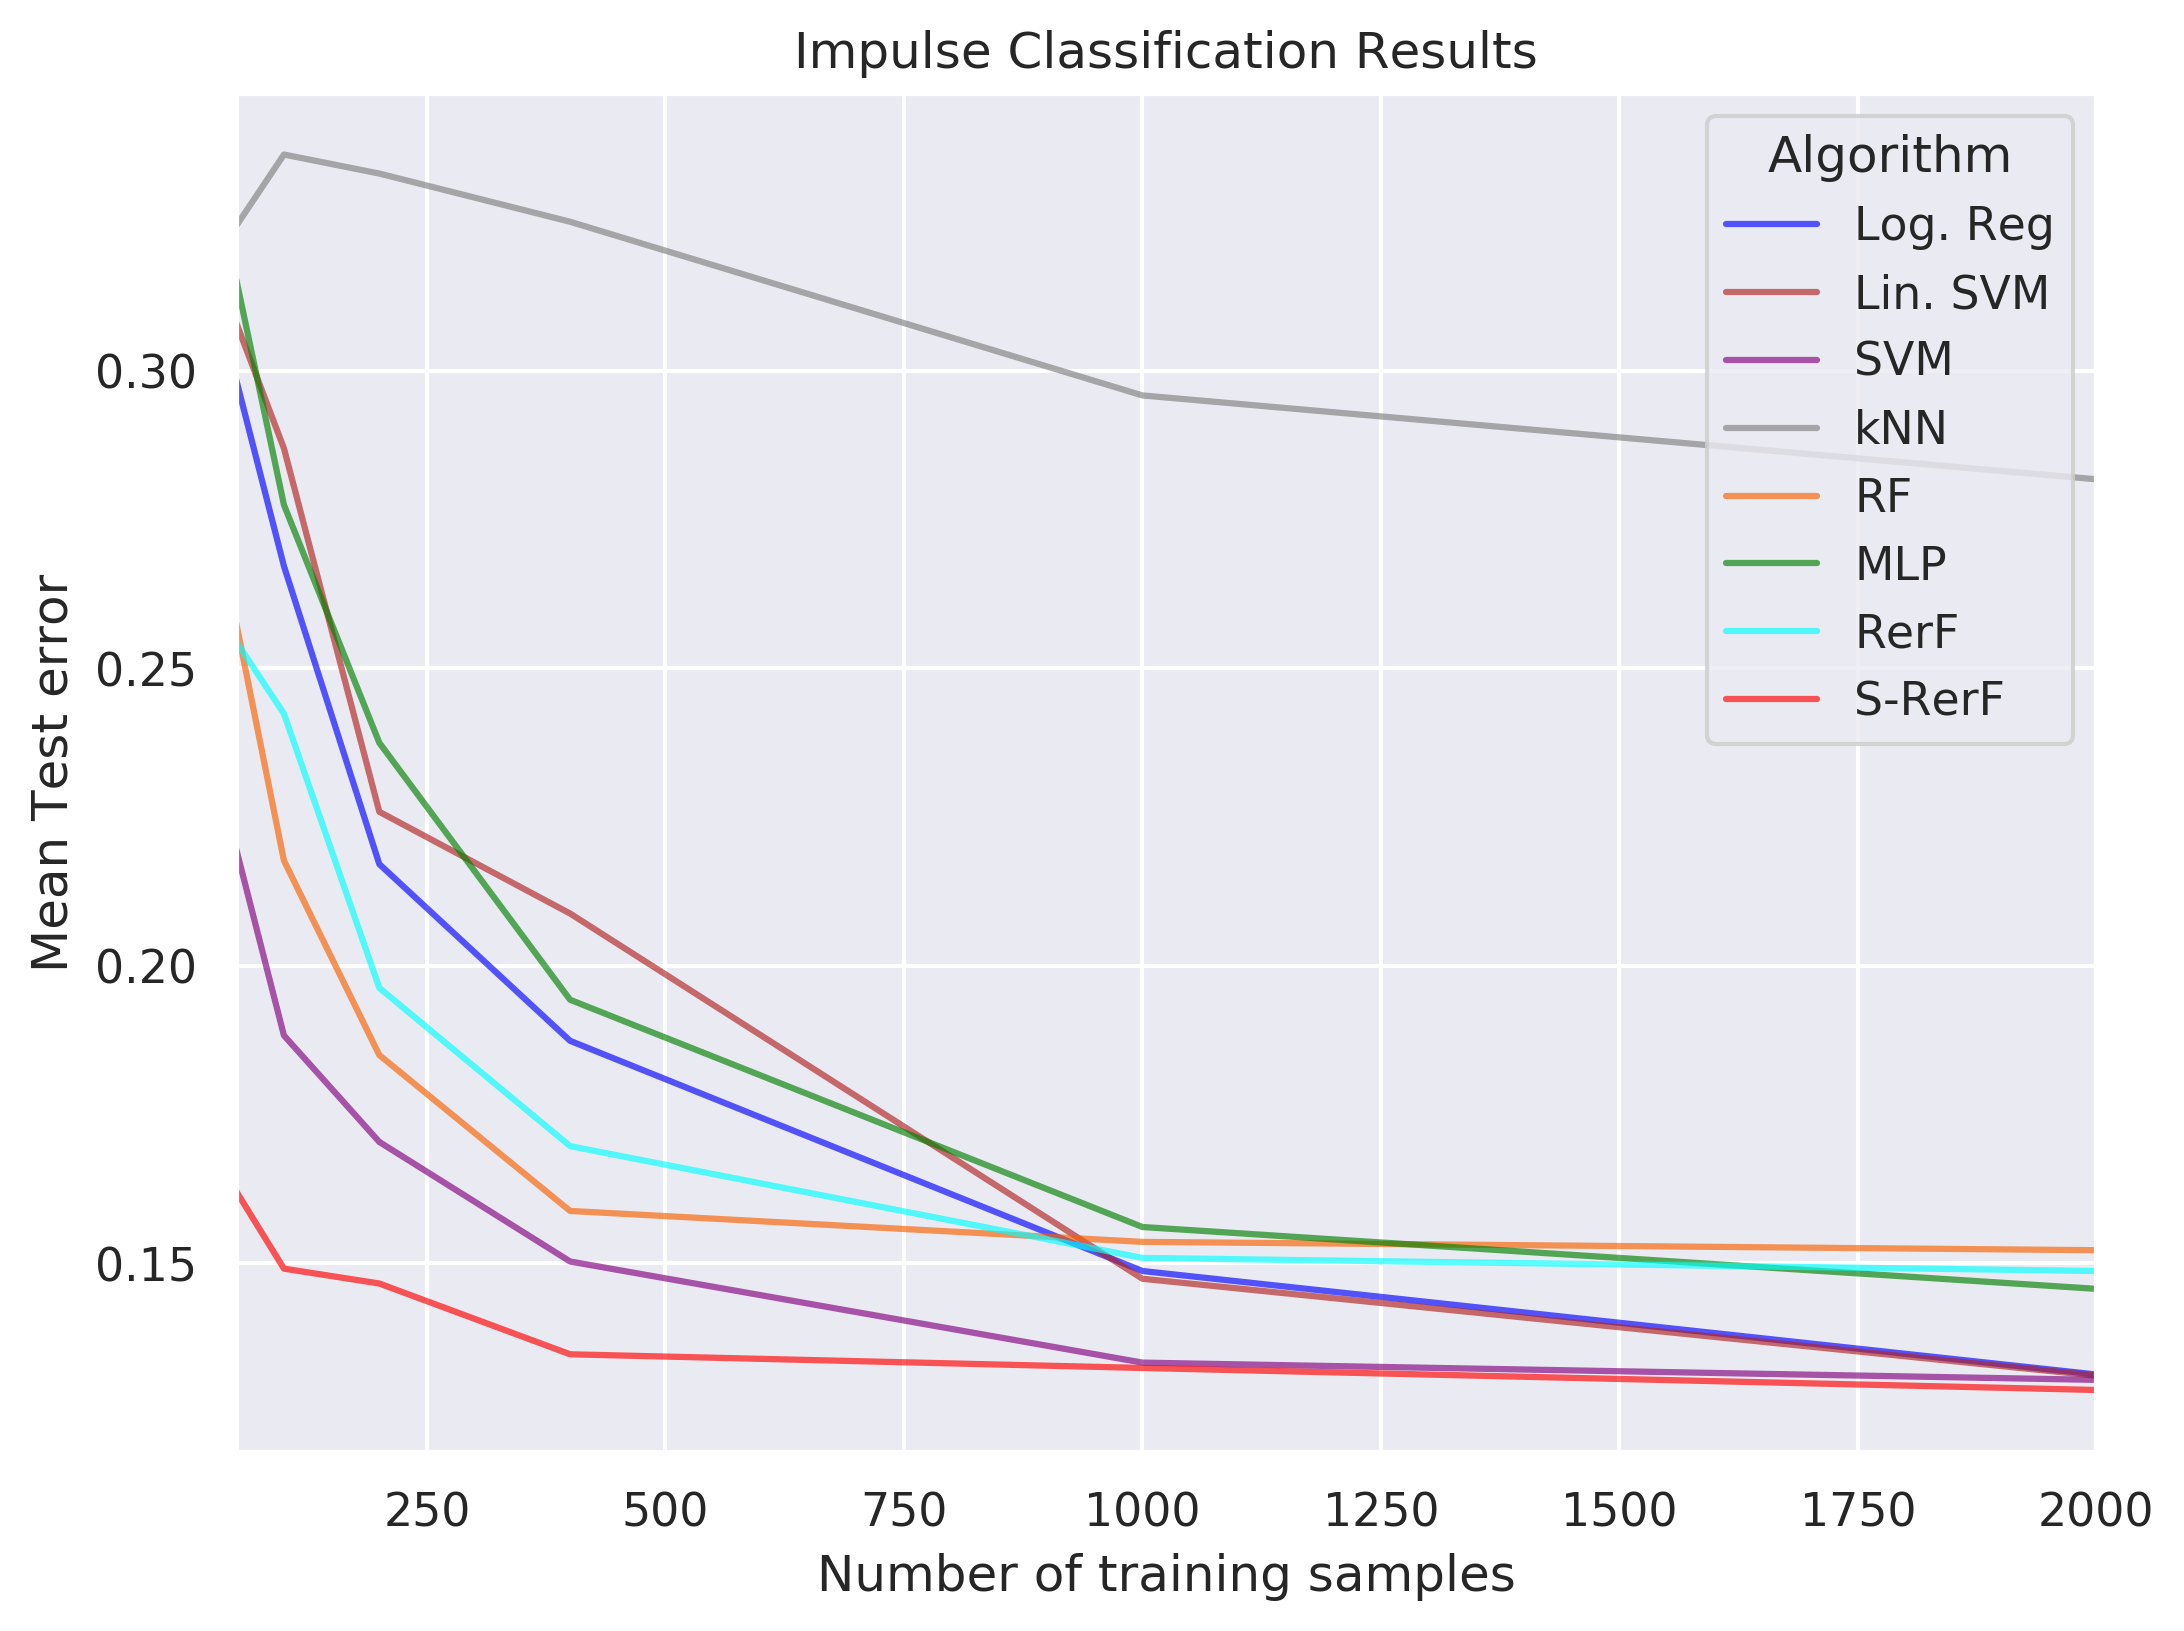

In [22]:
dat = pd.read_csv("s-rerf_impulse_experiment_rerf_1run.csv")

d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'se', 'color'])

k = 0
for ni in np.unique(dat['n']):
    for cl in np.unique(dat['classifier']):

        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Lhat']]

        se = stats.sem(tmp['Lhat'])
        
        list(tmp.mean())
        #d1.loc[k] = [cl] + list(tmp.mean()) + [se] + [names[cl]]
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1


sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})        
fig, ax = plt.subplots(figsize = (8,6))

for key in names.keys():
    grp = d1[d1['classifier'] == key] 
    ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
            c = names[key], alpha =0.65)
    #ax.set_yscale('log')

plt.legend(loc='upper right',title='Algorithm')
plt.title('Impulse Classification Results')
plt.ylabel('Mean Test error')
plt.xlabel('Number of training samples')
#plt.savefig('./s-rerf_impulse_experiment.pdf',dpi=300,format='pdf')
plt.show()